# Semantic Segmentation: SegFormer finetuned on SceneParse150

## Setup

In [38]:
import json
import yaml
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import ColorJitter
from torch.utils.data import DataLoader

from huggingface_hub import cached_download, hf_hub_url
from transformers import (
    AutoImageProcessor,
    SegformerForSemanticSegmentation,
    Trainer,
)
from datasets import load_dataset
import evaluate

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import optuna

In [2]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

zsh:1: /Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/bin/huggingface-cli: bad interpreter: /Users/mmenendezg/Developer/Projects/semantic-segmentation/.venv/bin/python: no such file or directory


In [3]:
MODEL_CHECKPOINT = "nvidia/segformer-b0-finetuned-ade-512-512"
BATCH_SIZE = 8

# Define the accelerator
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps:0")
    ACCELERATOR = "mps"
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    ACCELERATOR = "gpu"
else:
    DEVICE = torch.device("cpu")
    ACCELERATOR = "cpu"

## Load SceneParse150 dataset

In [4]:
dataset = load_dataset("scene_parse_150", split="train[:500]")

dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]
del dataset

In [5]:
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(
    open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


## Preprocess

In [6]:
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_CHECKPOINT, reduce_labels=True
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(batch):
    images = [jitter(image.convert("RGB")) for image in batch["image"]]
    labels = [mask for mask in batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(batch):
    images = [img.convert("RGB") for img in batch["image"]]
    labels = [mask for mask in batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [8]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [9]:
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE)

## Evaluate

In [10]:
dataset = load_dataset("scene_parse_150", split="train[:100]")

dataset = dataset.train_test_split(test_size=0.2)
train_sample_ds = dataset["train"]
test_sample_ds = dataset["test"]
del dataset

train_sample_ds.set_transform(train_transforms)
test_sample_ds.set_transform(val_transforms)

train_sample_dataloader = DataLoader(train_sample_ds, batch_size=BATCH_SIZE, shuffle=True)
test_sample_dataloader = DataLoader(test_sample_ds, batch_size=BATCH_SIZE)

In [11]:
class SegFormer(pl.LightningModule):
    def __init__(self, learning_rate, weight_decay):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            MODEL_CHECKPOINT, id2label=id2label, label2id=label2id
        )
        self.metric = evaluate.load("mean_iou")
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, pixel_values, labels):
        return self.model(pixel_values=pixel_values, labels=labels)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        return loss, logits

    def compute_metric(self, logits, labels):
        logits_tensor = nn.functional.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = self.metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )

        return metrics

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]

        # Calculate and log the loss
        loss, logits = self.common_step(batch, batch_idx)
        self.log("train_loss", loss)

        # Calculate and log the metrics
        metrics = self.compute_metric(logits, labels)
        metrics = {
            key: np.float32(value) for key, value in metrics.items()
        }
        # for k, v in metrics.items():
        #     self.log(f"train_{k}", v.item())
        self.log("train_mean_iou", metrics["mean_iou"])
        self.log("train_mean_accuracy", metrics["mean_accuracy"])
        self.log("train_overall_accuracy", metrics["overall_accuracy"])

        return loss

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]

        # Calculate and log the loss
        loss, logits = self.common_step(batch, batch_idx)
        self.log("val_loss", loss)

        # Calculate and log the metrics
        metrics = self.compute_metric(logits, labels)
        metrics = {
            key: np.float32(value) for key, value in metrics.items()
        }
        # for k, v in metrics.items():
        #     self.log(f"val_{k}", v.item())
        self.log("val_mean_iou", metrics["mean_iou"])
        self.log("val_mean_accuracy", metrics["mean_accuracy"])
        self.log("val_overall_accuracy", metrics["overall_accuracy"])

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters()],
                "lr": self.learning_rate,
            }
        ]
        return torch.optim.AdamW(
            param_dicts, lr=self.learning_rate, weight_decay=self.weight_decay
        )

In [12]:
def objective(trial: optuna.trial.Trial) -> float:
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Define the callbacks of the model
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=2)
    logger = TensorBoardLogger(save_dir=f"../reports/logs/trial_{trial.number}")

    # Create the model
    model = SegFormer(learning_rate=learning_rate, weight_decay=weight_decay)

    # Train the model
    trainer = Trainer(
        logger=logger,
        devices=1,
        accelerator=ACCELERATOR,
        max_epochs=5,
        gradient_clip_val=0.1,
        log_every_n_steps=5,
        callbacks=[early_stopping_cb],
    )
    trainer.fit(model, train_sample_dataloader, test_sample_dataloader)
    return trainer.callback_metrics["val_mean_iou"].item()

def get_best_params(force_tune: bool = False) -> dict:
    config_file = "../config/segformer_hp.yaml"

    if os.path.exists(config_file) and force_tune:
        os.remove(config_file)
        pruner = optuna.pruners.MedianPruner()
        study = optuna.create_study(direction="maximize", pruner=pruner)

        study.optimize(objective, n_trials=25)
        best_params = study.best_params
        with open(config_file, "w") as file:
            yaml.dump(best_params, file)
    elif os.path.exists(config_file):
        with open(config_file, "r") as file:
            best_params = yaml.safe_load(file)
    else:
        pruner = optuna.pruners.MedianPruner()
        study = optuna.create_study(direction="maximize", pruner=pruner)

        study.optimize(objective, n_trials=25)
        best_params = study.best_params
        with open(config_file, "w") as file:
            yaml.dump(best_params, file)
    
    return best_params

In [13]:
best_params = get_best_params()

## Train

In [17]:
model = SegFormer(
    learning_rate=best_params["learning_rate"], weight_decay=best_params["weight_decay"]
)

# Define the callbacks of the model
model_checkpoint_cb = ModelCheckpoint(save_top_k=1, dirpath=f"../models/SegFormer", monitor="val_loss")
logger = TensorBoardLogger(save_dir=f"../reports/logs/SegFormer")

# Train the model
trainer = Trainer(
    logger=logger,
    devices=1,
    accelerator=ACCELERATOR,
    precision=16,
    max_epochs=100,
    gradient_clip_val=0.1,
    log_every_n_steps=5,
    callbacks=[model_checkpoint_cb],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, train_dataloader, test_dataloader)


  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.8 M 
-----------------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.011    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Inference

In [ ]:
for batch in test_dataloader:
    images, masks = batch["pixel_values"], batch["labels"]
    outputs = model.model(images, masks)
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()



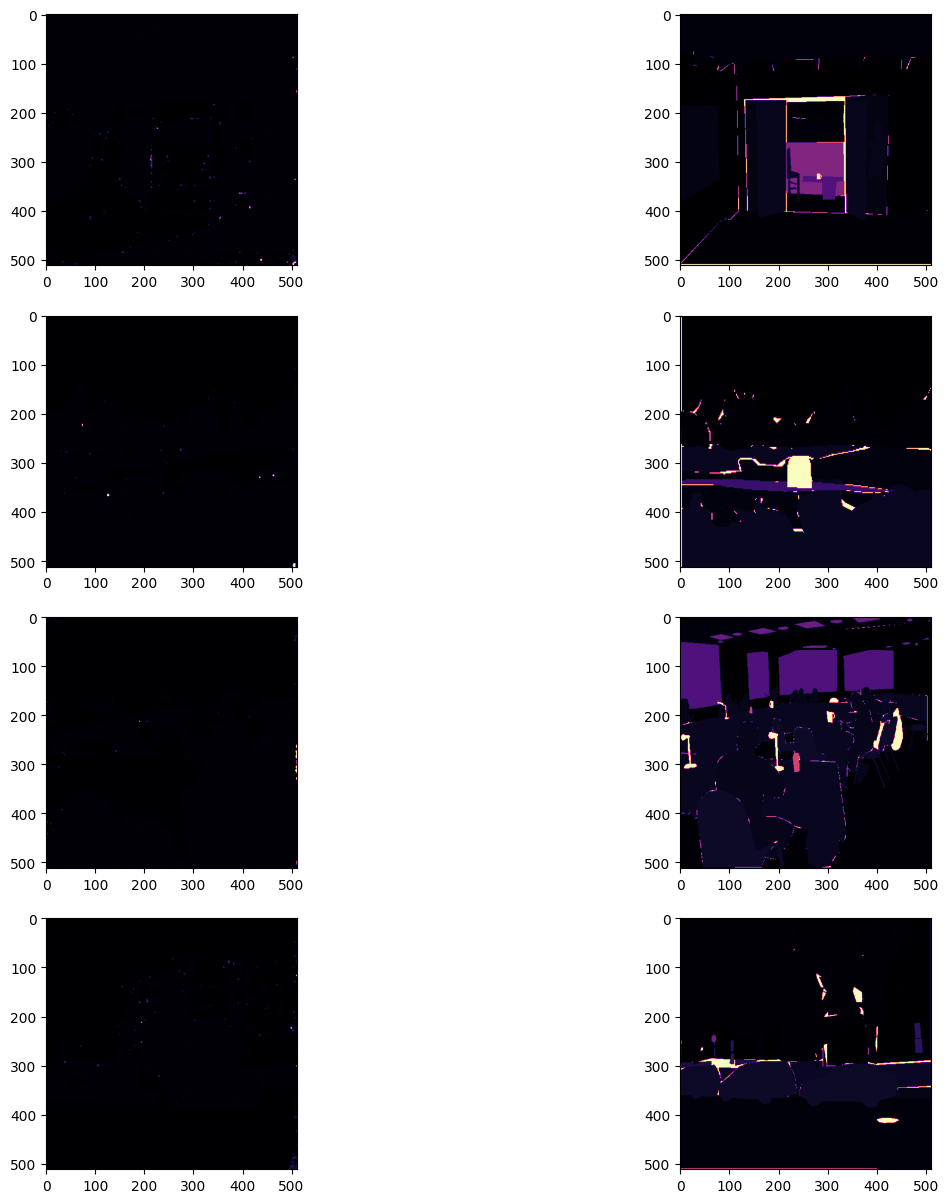

In [37]:
n_plots = 4
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    pred_mask = predicted_mask[i] / predicted_mask[i].max()
    mask = masks[i] / masks[i].max()
    axarr[i,0].imshow(pred_mask, cmap="magma")
    axarr[i,1].imshow(mask, cmap="magma")